<a href="https://colab.research.google.com/github/ThangLe2404/Diabetic_Microbiome_prediction/blob/main/Diabetic_Microbiome_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from imblearn.under_sampling import ClusterCentroids
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
import itertools
%matplotlib inline
from matplotlib.pylab import rcParams

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Project/abundance.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-98ec7320984f>:4: DtypeWarning: Columns (2,5,9,20,26,42,47,51,52,59,61,68,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Project/abundance.csv')


**PHÂN TÍCH DỮ LIỆU**

In [ ]:
df = df[df['disease'].isin(['n', 't2d'])]
df['disease'] = df['disease'].replace('n', 'non_t2d')

df_sp=df.loc[:,df.columns.str.contains('s__')]
df_vi=pd.concat([df['disease'],df_sp], axis=1)

df_vi['disease'].value_counts()

non_t2d    2054
t2d         223
Name: disease, dtype: int64

**LỌC FEATURES**

In [ ]:
data_t2d = df_vi[df_vi['disease'] == 't2d']
data_check = data_t2d.iloc[:, 1:] > 0.05
data_check = data_check.sum()
df_check = pd.DataFrame({'bacteria':data_check.index, 'cnt_exist':data_check.values})
t2d_vsv=df_check[df_check['cnt_exist'] > 10]
t2d_vsv = t2d_vsv.sort_values(by=['cnt_exist'], ascending=False)
t2d_vsv

data_non_t2d = df_vi[df_vi['disease'] == 'non_t2d']
data_check = data_non_t2d.iloc[:, 1:] > 0.20
data_check = data_check.sum()
df_check = pd.DataFrame({'bacteria':data_check.index, 'cnt_exist':data_check.values})
non_t2d_vsv=df_check[df_check['cnt_exist'] > 300]
non_t2d_vsv = non_t2d_vsv.sort_values(by=['cnt_exist'], ascending=False)
non_t2d_vsv

listvsv=list(set(non_t2d_vsv['bacteria'].to_list()+t2d_vsv['bacteria'].to_list()))
len(listvsv)

O=listvsv
O.insert(0,'disease')
df_vi=df_vi[O]
df_vi

,disease,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_epidermidis|t__Staphylococcus_epidermidis_unclassified,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_sp_ART55_1,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_thetaiotaomicron|t__Bacteroides_thetaiotaomicron_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum|t__Bifidobacterium_longum_unclassified,k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ruminis|t__Lactobacillus_ruminis_unclassified,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula|t__Veillonella_parvula_unclassified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_citroniae|t__GCF_000233455,...,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_shahii|t__GCF_000210575,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus|t__Bacteroides_cellulosilyticus_unclassified,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Clostridiales_bacterium_1_7_47FAA|t__GCF_000155435,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprophilus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_clarus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ventriosum|t__GCF_000153885,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hydrogenotrophica|t__GCF_000157975,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_senegalensis|t__GCF_000312145,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus
0,non_t2d,0.0,2.29030,0.00000,0.00000,0.00000,0.16770,0.00456,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.14639,0.00000,0.00000,0.00000,0.00000
1,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00594,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.12173,0.00000,0.00000,0.00000,0.00000
2,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.43139,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.05932,0.00000,0.00000,0.00000,0.00000
3,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00810,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.01625,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,non_t2d,0.0,0.00000,3.83649,5.78432,2.22155,0.00000,0.00000,3.03469,0.00413,...,0.00000,0.0,0.01046,0.00000,6.32332,0.00000,0.00000,0.14643,0.00000,0.53683
3602,non_t2d,0.0,2.57355,0.03370,0.26925,0.00000,0.00000,0.00000,0.47964,0.00000,...,0.02533,0.0,0.00000,0.78008,0.03541,1.72337,0.00000,0.00000,0.00244,4.71695
3604,non_t2d,0.0,0.00000,0.45916,1.33828,0.00498,0.00000,0.00000,0.00048,0.02324,...,0.00000,0.0,0.01345,0.00000,0.0000

**Xử lý tên Features (làm gọn tên-bỏ phân loại lớn)**

In [ ]:
xl=df_vi.columns[1:].tolist()
for i in range(len(xl)):
  xl[i]='s__'+xl[i].split('s__')[1]
print(xl)

xl.insert(0,'disease')
df_vi.columns=xl
df_vi

['s__Staphylococcus_epidermidis|t__Staphylococcus_epidermidis_unclassified', 's__Coprococcus_sp_ART55_1', 's__Bacteroides_thetaiotaomicron|t__Bacteroides_thetaiotaomicron_unclassified', 's__Bifidobacterium_longum|t__Bifidobacterium_longum_unclassified', 's__Coprobacillus_unclassified', 's__Lactobacillus_ruminis|t__Lactobacillus_ruminis_unclassified', 's__Veillonella_parvula|t__Veillonella_parvula_unclassified', 's__Bacteroides_caccae', 's__Clostridium_citroniae|t__GCF_000233455', 's__Coprobacillus_sp_D6', 's__Bilophila_unclassified', 's__Streptococcus_infantis', 's__Anaerostipes_hadrus', 's__Bifidobacterium_dentium', 's__Lachnospiraceae_bacterium_3_1_46FAA|t__GCF_000209405', 's__Bacteroides_salyersiae|t__Bacteroides_salyersiae_unclassified', 's__Bifidobacterium_bifidum|t__Bifidobacterium_bifidum_unclassified', 's__Streptococcus_anginosus|t__Streptococcus_anginosus_unclassified', 's__Subdoligranulum_unclassified', 's__Bacteroides_massiliensis', 's__Granulicatella_adiacens', 's__Clostrid

,disease,s__Staphylococcus_epidermidis|t__Staphylococcus_epidermidis_unclassified,s__Coprococcus_sp_ART55_1,s__Bacteroides_thetaiotaomicron|t__Bacteroides_thetaiotaomicron_unclassified,s__Bifidobacterium_longum|t__Bifidobacterium_longum_unclassified,s__Coprobacillus_unclassified,s__Lactobacillus_ruminis|t__Lactobacillus_ruminis_unclassified,s__Veillonella_parvula|t__Veillonella_parvula_unclassified,s__Bacteroides_caccae,s__Clostridium_citroniae|t__GCF_000233455,...,s__Alistipes_shahii|t__GCF_000210575,s__Bacteroides_cellulosilyticus|t__Bacteroides_cellulosilyticus_unclassified,s__Clostridiales_bacterium_1_7_47FAA|t__GCF_000155435,s__Bacteroides_coprophilus,s__Bacteroides_clarus,s__Eubacterium_ventriosum|t__GCF_000153885,s__Blautia_hydrogenotrophica|t__GCF_000157975,s__Sutterella_wadsworthensis,s__Alistipes_senegalensis|t__GCF_000312145,s__Bacteroides_vulgatus
0,non_t2d,0.0,2.29030,0.00000,0.00000,0.00000,0.16770,0.00456,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.14639,0.00000,0.00000,0.00000,0.00000
1,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00594,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.12173,0.00000,0.00000,0.00000,0.00000
2,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.43139,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.05932,0.00000,0.00000,0.00000,0.00000
3,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00810,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,non_t2d,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.01625,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,non_t2d,0.0,0.00000,3.83649,5.78432,2.22155,0.00000,0.00000,3.03469,0.00413,...,0.00000,0.0,0.01046,0.00000,6.32332,0.00000,0.00000,0.14643,0.00000,0.53683
3602,non_t2d,0.0,2.57355,0.03370,0.26925,0.00000,0.00000,0.00000,0.47964,0.00000,...,0.02533,0.0,0.00000,0.78008,0.03541,1.72337,0.00000,0.00000,0.00244,4.71695
3604,non_t2d,0.0,0.00000,0.45916,1.33828,0.00498,0.00000,0.00000,0.00048,0.02324,...,0.00000,0.0,0.01345,0.00000,0.00000,0.00504,0.00775,0.00000,0.00000,1.97624
3605,non_t2d,0.0,11.17366,0.00000,1.24593,0.00000,0.00000,0.00000,0.35247,0.00000,...,0.10169,0.0,0.00000,0.00000,0.00000,0.01814,0.00000,0.00000,0.01034,0.15627


**DATA EXPLORATION**

In [ ]:
df_vi.describe()

,s__Staphylococcus_epidermidis|t__Staphylococcus_epidermidis_unclassified,s__Coprococcus_sp_ART55_1,s__Bacteroides_thetaiotaomicron|t__Bacteroides_thetaiotaomicron_unclassified,s__Bifidobacterium_longum|t__Bifidobacterium_longum_unclassified,s__Coprobacillus_unclassified,s__Lactobacillus_ruminis|t__Lactobacillus_ruminis_unclassified,s__Veillonella_parvula|t__Veillonella_parvula_unclassified,s__Bacteroides_caccae,s__Clostridium_citroniae|t__GCF_000233455,s__Coprobacillus_sp_D6,...,s__Alistipes_shahii|t__GCF_000210575,s__Bacteroides_cellulosilyticus|t__Bacteroides_cellulosilyticus_unclassified,s__Clostridiales_bacterium_1_7_47FAA|t__GCF_000155435,s__Bacteroides_coprophilus,s__Bacteroides_clarus,s__Eubacterium_ventriosum|t__GCF_000153885,s__Blautia_hydrogenotrophica|t__GCF_000157975,s__Sutterella_wadsworthensis,s__Alistipes_senegalensis|t__GCF_000312145,s__Bacteroides_vulgatus
count,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,...,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000,2277.000000
mean,2.535993,0.459973,0.638179,0.311222,0.029605,0.051064,0.393646,0.818958,0.006718,0.007409,...,0.348237,0.553713,0.007220,0.178847,0.062146,0.161169,0.002978,0.164161,0.018040,1.915071
std,9.930792,1.983807,2.328513,1.402678,0.249642,0.904426,1.202551,2.805707,0.030665,0.079399,...,0.949983,2.273924,0.052562,1.350344,0.407087,0.598089,0.021847,0.702488,0.073629,4.642187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007060
75%,0.000000,0.000000,0.356010,0.043360,0.000000,0.000000,0.172140,0.434490,0.000000,0.000000,...,0.253810,0.046570,0.000000,0.000000,0.000000,0.072560,0.000000,0.000000,0.002050,1.688490
max,95.079410,29.369660,36.587880,37.045260,7.153490,41.198680,16.121590,53.021520,0.740730,1.719210,...,17.265080,35.582280,2.034730,26.819060,7.461610,11.234920,0.524150,13.409880,1.371470,53.578160


In [ ]:
df_vi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 0 to 3607
Columns: 365 entries, disease to s__Bacteroides_vulgatus
dtypes: float64(364), object(1)
memory usage: 6.4+ MB


In [ ]:
df_vi_t2d=df_vi[df_vi['disease']=='t2d'].iloc[:, 1:]
df_vi_non_t2d=df_vi[df_vi['disease']=='non_t2d'].iloc[:, 1:]
e=df_vi_non_t2d
t2d_de=df_vi_t2d.mean().sort_values(ascending=False).index.tolist()[:20]
non_t2d_de=df_vi_non_t2d.mean().sort_values(ascending=False).index.tolist()[:20]
df_vi_t2d=df_vi_t2d[t2d_de]
df_vi_non_t2d=df_vi_non_t2d[non_t2d_de]
#df_vi_t2d
#df_vi_non_t2d
df_vi_non_t2d1=e[t2d_de]

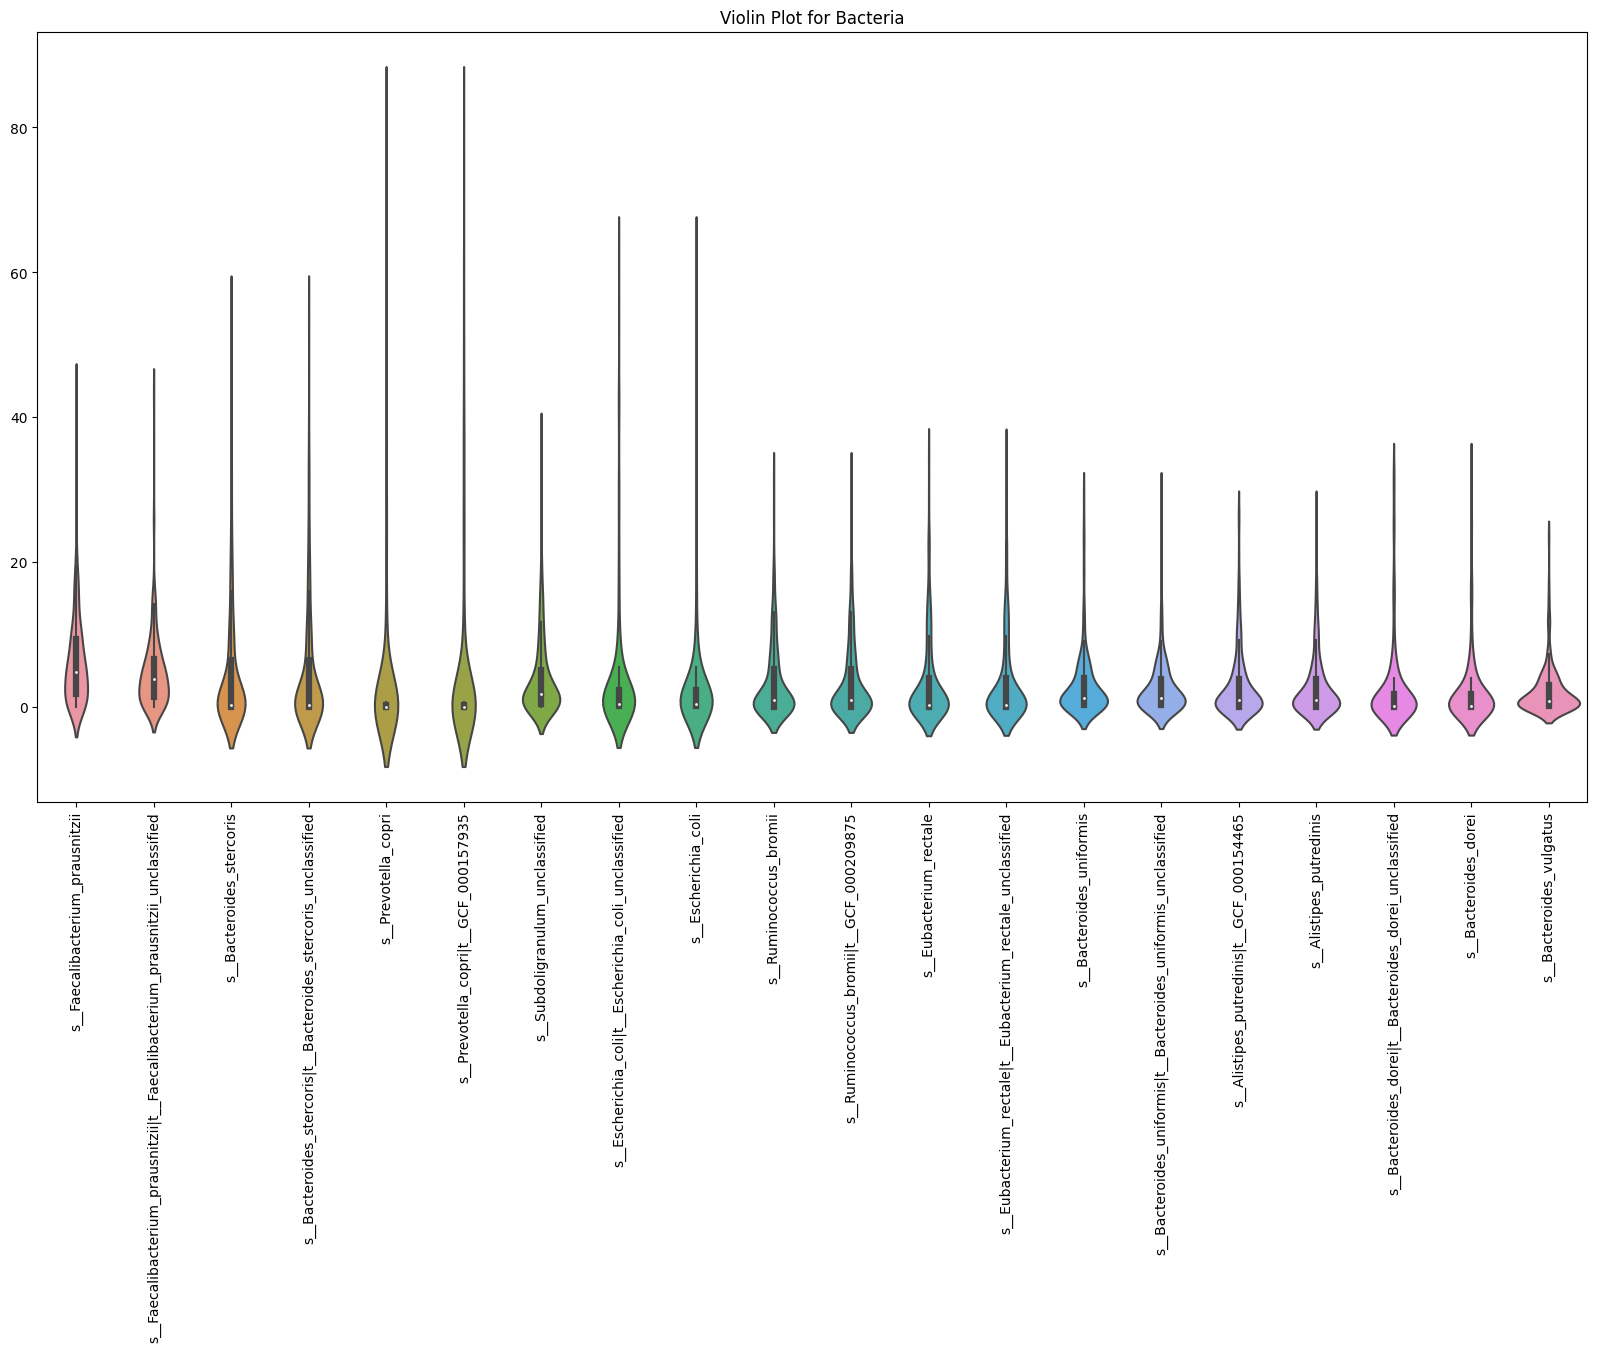

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))

# Create the violin plot
vp = sns.violinplot(data=df_vi_t2d)

# Add title and rotate x-axis labels
plt.title("Violin Plot for Bacteria")
plt.xticks(range(len(df_vi_t2d.columns)), df_vi_t2d.columns, rotation=90)

# Show the plot
plt.show()

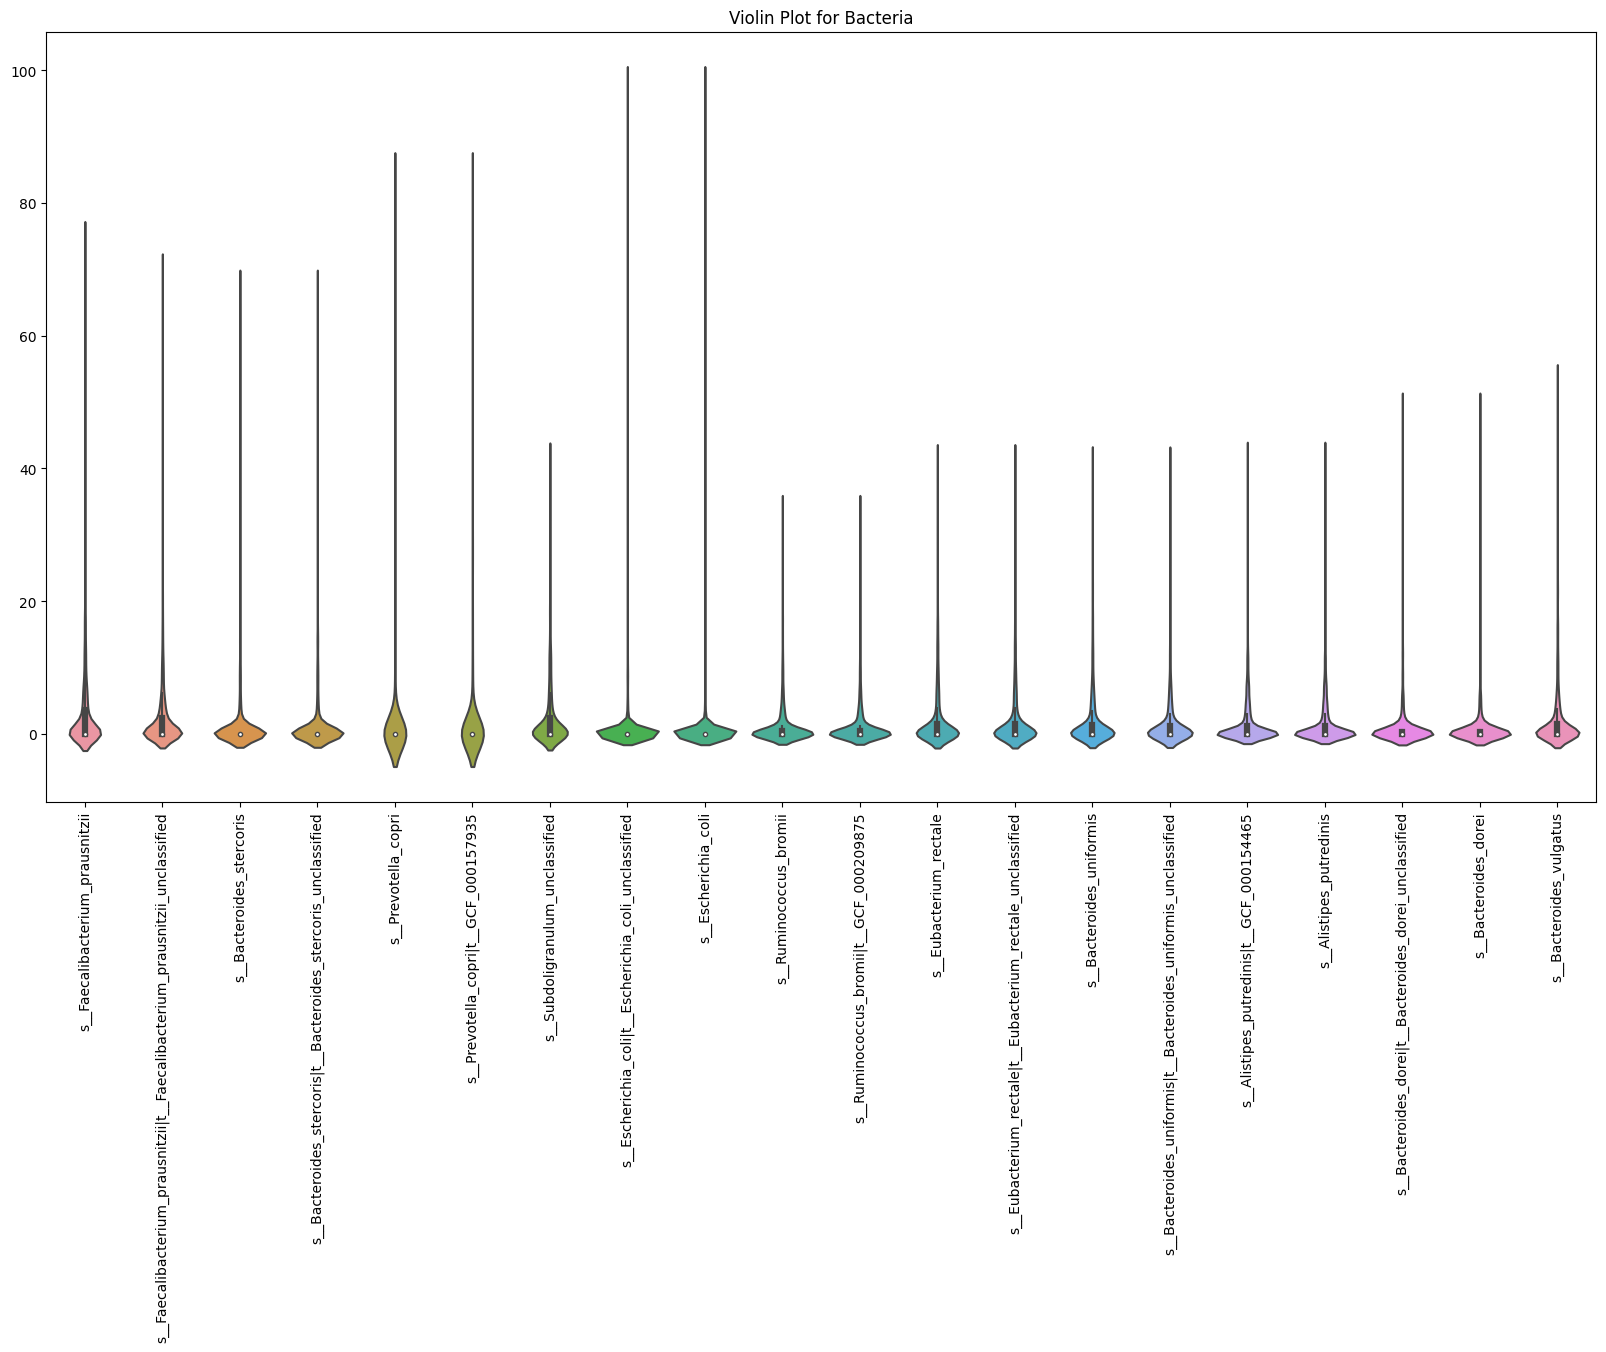

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))

# Create the violin plot
vp = sns.violinplot(data=df_vi_non_t2d1)

# Add title and rotate x-axis labels
plt.title("Violin Plot for Bacteria")
plt.xticks(range(len(df_vi_non_t2d1.columns)), df_vi_non_t2d1.columns, rotation=90)

# Show the plot
plt.show()

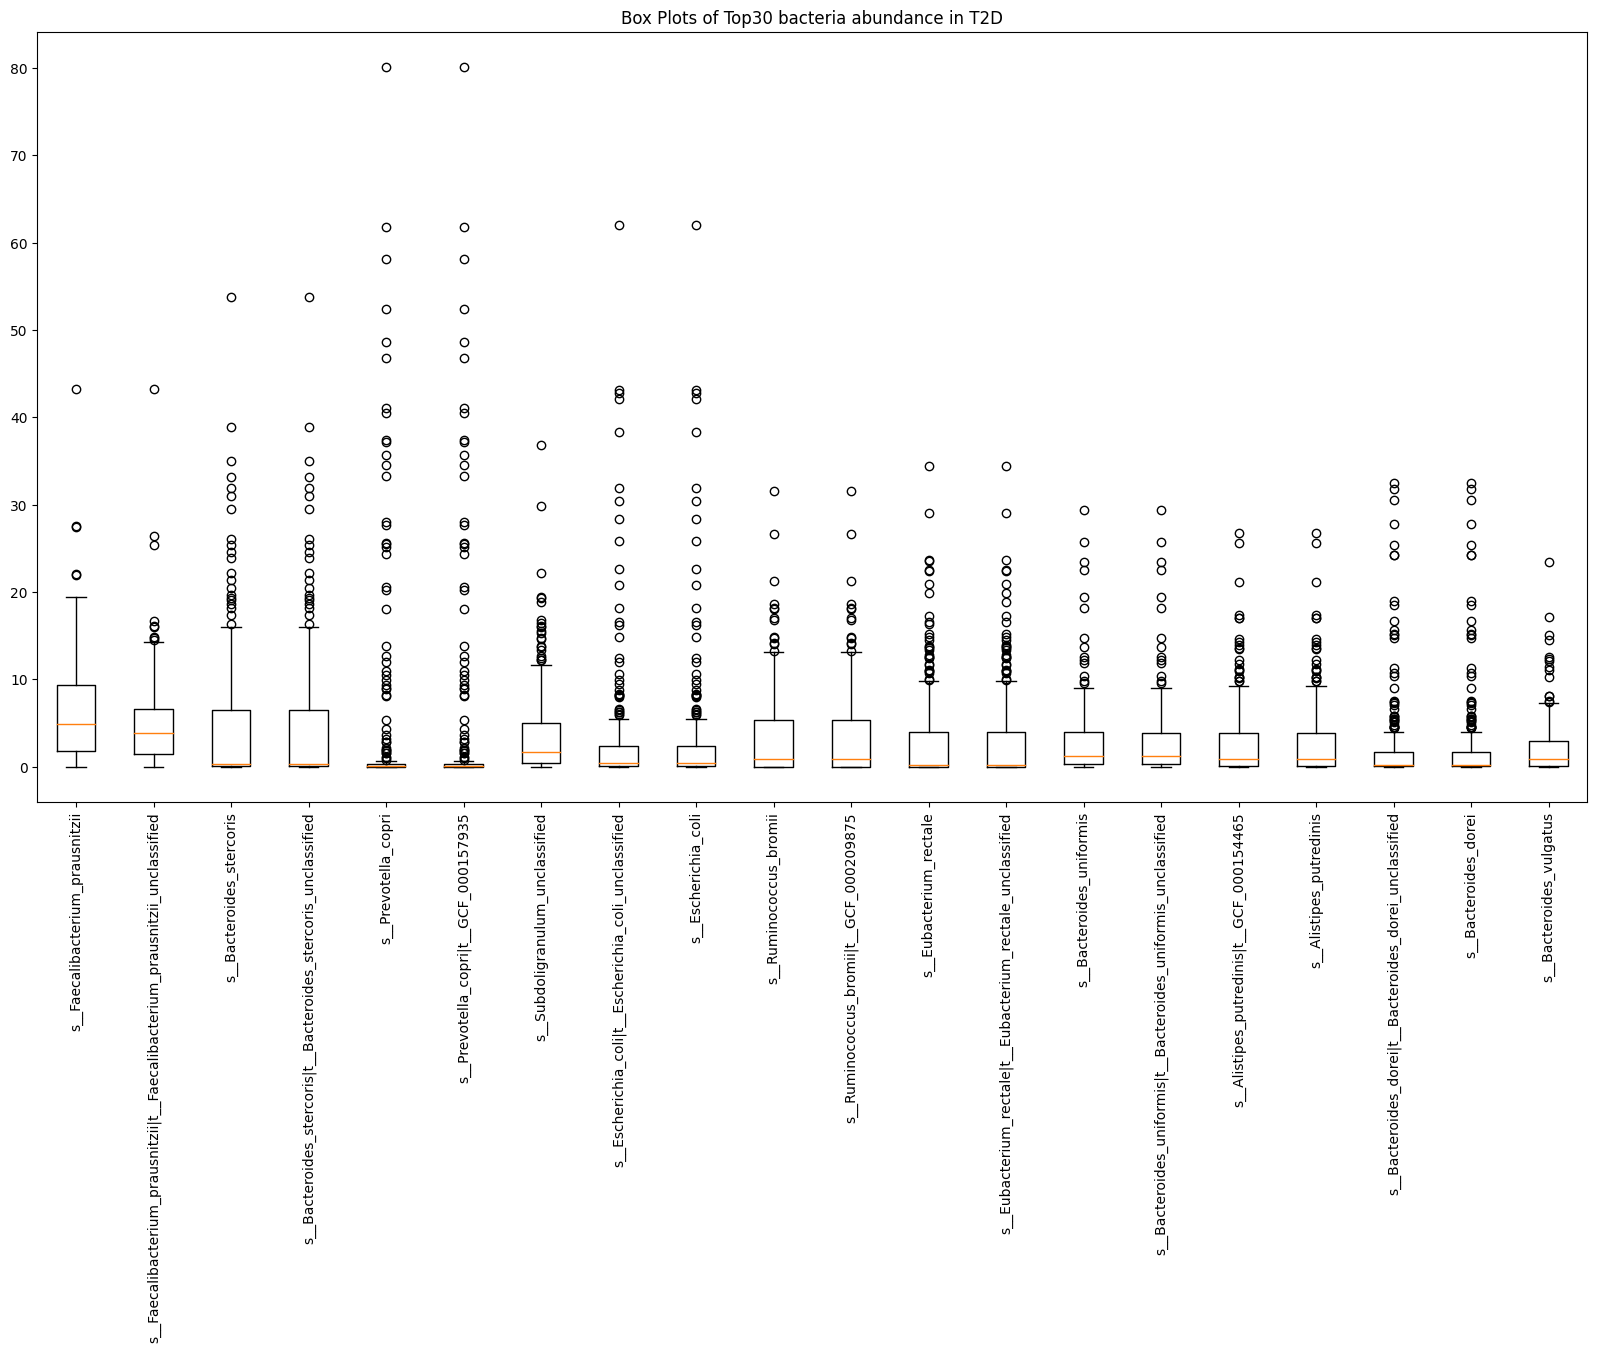

In [ ]:
# Iterate through each column and create scatter plots
plt.figure(figsize=(20, 10))
# for column in df_vi_t2d.columns:
plt.boxplot(df_vi_t2d.values, labels=df_vi_t2d.columns)
# plt.boxplot(df_vi_t2d[column], labels=df_vi_t2d.columns)
plt.title("Box Plots of Top30 bacteria abundance in T2D")
# plt.legend()
plt.xticks(rotation=90)
# Show the plot
plt.show()

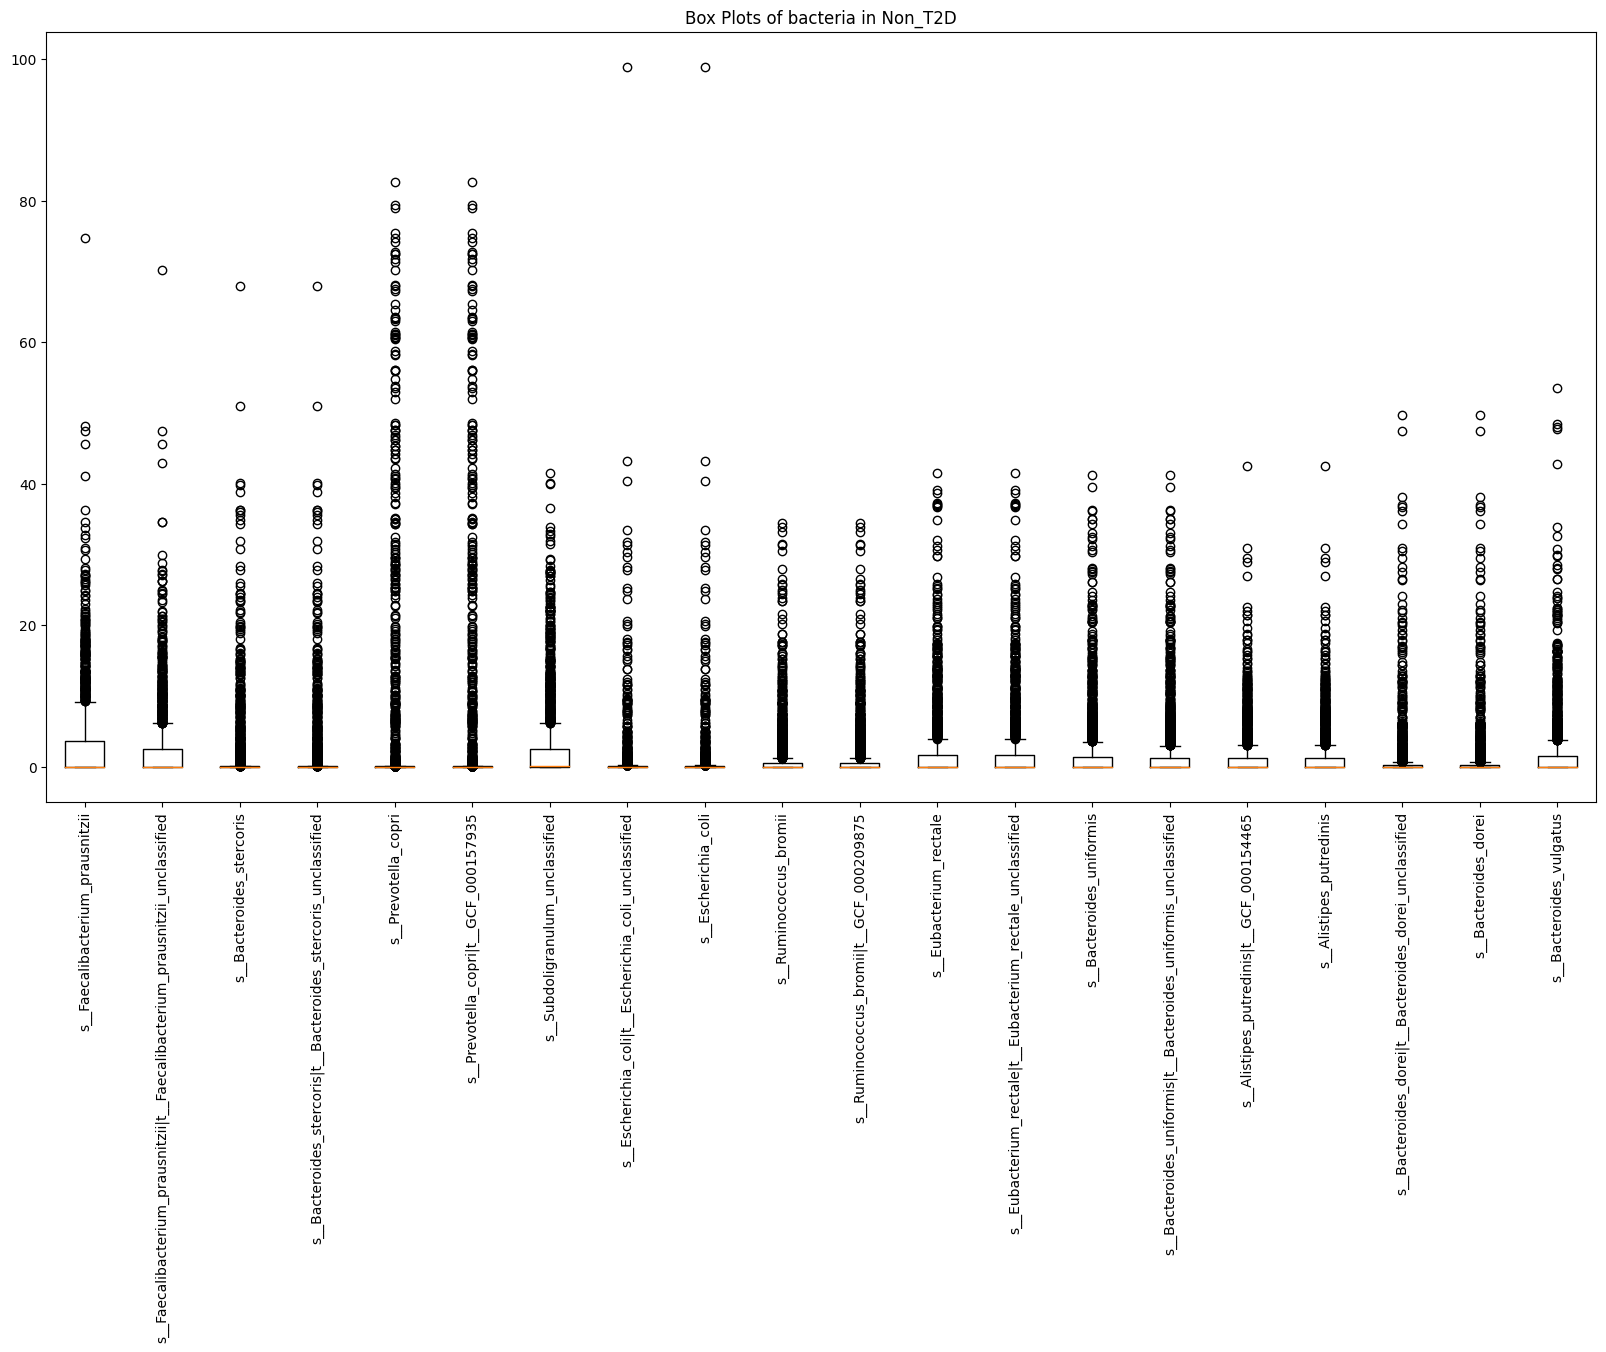

In [ ]:
# Iterate through each column and create scatter plots
plt.figure(figsize=(20, 10))
# for column in df_vi_t2d.columns:
plt.boxplot(df_vi_non_t2d1.values, labels=df_vi_non_t2d1.columns)
# plt.boxplot(df_vi_t2d[column], labels=df_vi_t2d.columns)
plt.title("Box Plots of bacteria in Non_T2D")
# plt.legend()
plt.xticks(rotation=90)
# Show the plot
plt.show()

**MODEL**

In [ ]:
#lấy dữ liệu test
test_non_t2d=df_vi[df_vi['disease']=='non_t2d'].sample(300,random_state=0)
test_t2d=df_vi[df_vi['disease']=='t2d'].sample(35,random_state=0)

test=pd.concat([test_non_t2d,test_t2d],ignore_index=True)
test

,disease,s__Staphylococcus_epidermidis|t__Staphylococcus_epidermidis_unclassified,s__Coprococcus_sp_ART55_1,s__Bacteroides_thetaiotaomicron|t__Bacteroides_thetaiotaomicron_unclassified,s__Bifidobacterium_longum|t__Bifidobacterium_longum_unclassified,s__Coprobacillus_unclassified,s__Lactobacillus_ruminis|t__Lactobacillus_ruminis_unclassified,s__Veillonella_parvula|t__Veillonella_parvula_unclassified,s__Bacteroides_caccae,s__Clostridium_citroniae|t__GCF_000233455,...,s__Alistipes_shahii|t__GCF_000210575,s__Bacteroides_cellulosilyticus|t__Bacteroides_cellulosilyticus_unclassified,s__Clostridiales_bacterium_1_7_47FAA|t__GCF_000155435,s__Bacteroides_coprophilus,s__Bacteroides_clarus,s__Eubacterium_ventriosum|t__GCF_000153885,s__Blautia_hydrogenotrophica|t__GCF_000157975,s__Sutterella_wadsworthensis,s__Alistipes_senegalensis|t__GCF_000312145,s__Bacteroides_vulgatus
0,non_t2d,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.52692,0.00000,0.00000,...,0.00000,0.00211,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00383
1,non_t2d,0.00000,0.00000,0.30415,0.03895,0.00000,0.00000,0.02974,0.00000,0.00000,...,0.06985,0.00000,0.00000,4.63246,0.00000,0.00000,0.00000,0.00000,0.00000,0.93119
2,non_t2d,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,non_t2d,0.00000,5.54767,0.06433,0.05506,0.00000,0.14493,0.00000,0.00000,0.00000,...,0.28780,0.00000,0.00000,6.51420,0.03497,0.02036,0.00000,0.90611,0.02871,0.89211
4,non_t2d,0.39896,0.00000,0.11291,0.21076,0.00000,0.00000,0.30212,0.00000,0.00000,...,0.08039,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00937,0.82590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,t2d,0.00000,0.00000,0.00000,2.27495,0.00127,0.88961,5.34258,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.11574
331,t2d,0.00000,0.00000,1.03062,2.12490,0.02656,1.79641,0.20066,0.22672,0.00703,...,1.19422,0.30493,0.00511,0.00000,0.07898,0.81281,0.00000,0.00000,0.02962,0.70395
332,t2d,0.00000,0.00000,0.84311,0.58136,0.00000,0.00000,0.00000,1.30537,0.04535,...,0.23576,9.12694,0.24841,0.00000,0.08181,0.00000,0.00000,0.00000,0.00000,0.82832
333,t2d,0.00000,0.00000,6.15484,0.00000,0.12346,0.00000,0.01450,0.00000,0.02371,...,0.00000,0.00000,0.00177,0.00000,0.00000,0.34009,0.08431,0.03753,0.00000,0.00000


In [ ]:
#tập train
m=test_non_t2d.index.to_list()
n=test_t2d.index.to_list()
m.extend(n)
m

train=df_vi[~df_vi.index.isin(m)]

In [ ]:
train
train['disease'].value_counts()

non_t2d    1754
t2d         188
Name: disease, dtype: int64

In [ ]:
y_train=train['disease']
X_train=train.drop('disease', axis=1)

y_test=test['disease']
X_test=test.drop('disease', axis=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1942, 364) (1942,)
(335, 364) (335,)


In [ ]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)

y_test = label_encoder.fit_transform(y_test)

# X_train = MinMaxScaler().fit_transform(X_train)
# X_train
# X_test = MinMaxScaler().fit_transform(X_test)
# X_test

In [ ]:
cc = ClusterCentroids(sampling_strategy=0.8, random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j] * 100, fmt) + "%",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Train Result:
LogisticRegression(random_state=0) :Accuracy: 74.44 %
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.973684    0.933333  0.955083    0.953509      0.955750
recall       0.944681    0.968085  0.955083    0.956383      0.955083
f1-score     0.958963    0.950392  0.955083    0.954677      0.955154
support    235.000000  188.000000  0.955083  423.000000    423.000000
_______________________________________________
Confusion Matrix: 
 [[222  13]
 [  6 182]]


Test Result:
Accuracy Score: 85.37%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.980843   0.405405  0.853731    0.693124      0.920723
recall       0.853333   0.857143  0.853731    0.855238      0.853731
f1-score     0.912656   0.550459  0.853731    0.731557      0.874814
support    300.000000  35.000000  0

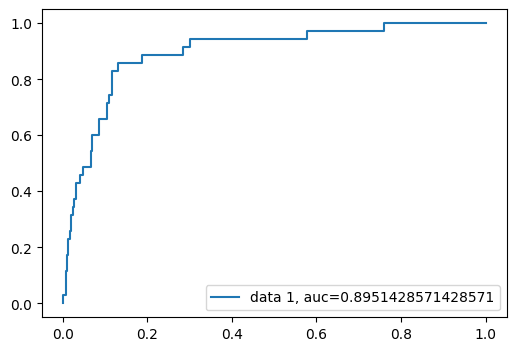

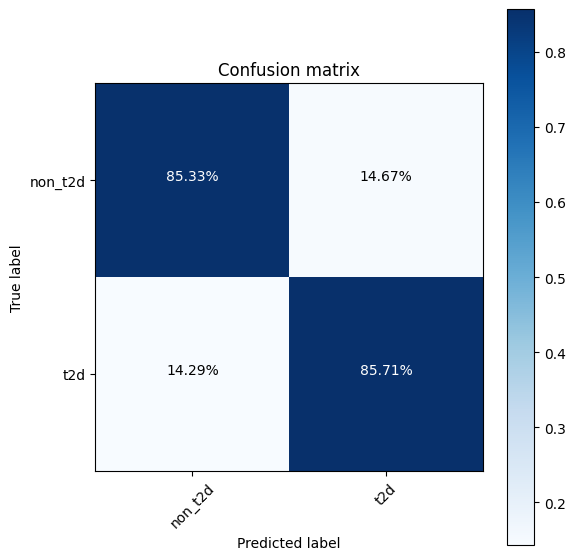

In [ ]:
clf_log = LogisticRegression(random_state=0)
model=clf_log.fit(X_resampled, y_resampled)
y_pred_train = clf_log.predict(X_resampled)
accuracies = cross_val_score(estimator = clf_log, X = X_resampled, y = y_resampled, cv = 10)
clf_report = pd.DataFrame(classification_report(y_resampled, y_pred_train, output_dict=True))
print("Train Result:\n================================================")
print(clf_log,":Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_resampled, y_pred_train)}\n")


pred = clf_log.predict(X_test)
clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")

cm=confusion_matrix(y_test, pred)
print(f"Confusion Matrix: \n {cm}\n")

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
auc_score = metrics.auc(fpr, tpr)
print("AUC:       {}".format(auc_score))

#Specificity = TN / TN + FP
true_pos = cm[0, 0]
false_pos = cm[0, 1]
false_neg = cm[1, 0]
true_neg = cm[1, 1]
Specificity=true_neg/(true_neg+false_neg)
print("Specificity:  {}".format(Specificity))

#Sensitivity = TP / TP+FN
Sensitivity = true_pos/(true_pos+false_neg)
print("Sensitivity:  {}".format(Sensitivity))

y_pred_proba = clf_log.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
rcParams['figure.figsize'] =6,4
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

plot_confusion_matrix(confusion_matrix(y_test, pred),label_encoder.classes_, title='Confusion matrix', cmap=plt.cm.Blues)

In [ ]:
clf_log.coef_
feature_names = train.columns[1:].tolist()
feature_score = clf_log.coef_[0].tolist()

list_feature = dict.fromkeys(feature_names)

for i, key in enumerate(list_feature):
    list_feature[key] = feature_score[i]
list_feature

list_feature = dict(sorted(list_feature.items(), key=lambda item: item[1], reverse=True))
top_15_model = dict(list(list_feature.items())[0: 100])
top_15_model

my_list = list(top_15_model.keys())
my_list

['s__Bilophila_unclassified',
 's__Clostridium_bolteae',
 's__Clostridium_bolteae|t__Clostridium_bolteae_unclassified',
 's__Escherichia_unclassified',
 's__Lactobacillus_mucosae',
 's__Lactobacillus_mucosae|t__GCF_000248095',
 's__Clostridium_hathewayi',
 's__Coprococcus_catus',
 's__Coprococcus_catus|t__GCF_000210555',
 's__Alistipes_finegoldii|t__GCF_000265365',
 's__Alistipes_finegoldii',
 's__Ruminococcus_callidus|t__GCF_000468015',
 's__Ruminococcus_callidus',
 's__Bacteroides_uniformis|t__Bacteroides_uniformis_unclassified',
 's__Alistipes_indistinctus|t__GCF_000231275',
 's__Alistipes_indistinctus',
 's__Megasphaera_unclassified',
 's__Parasutterella_excrementihominis',
 's__Parasutterella_excrementihominis|t__GCF_000205025',
 's__Ruminococcus_obeum',
 's__Dorea_longicatena|t__GCF_000154065',
 's__Dorea_longicatena',
 's__Bacteroides_xylanisolvens',
 's__Eubacterium_siraeum|t__Eubacterium_siraeum_unclassified',
 's__Collinsella_aerofaciens|t__GCF_000169035',
 's__Collinsella_ae

**Assosiation rule**

In [ ]:
%pip install mlxtend

In [ ]:
# Tạo 1 df chỉ chứa prefix (Không chứa đuôi vi khuẩn t__ trong tên vi khuẩn)
df_vi_prefix = df_vi.loc[:, ~df_vi.columns.str.contains('t__')]

# Tạo 1 df chỉ chứa tên đầy đủ (có t__ trong tên vi khuẩn)
df_vi_full_prefix = df_vi.loc[:, df_vi.columns.str.contains('t__')]

# Lấy tên các cột tương ứng ở 2 df vừa tạo
lst_bacteria_full_prefix = df_vi_full_prefix.columns.values.tolist()
lst_bacteria_prefix = df_vi_prefix.columns.values.tolist()

# Duyệt từng vi khuẩn trong list đầy đủ
for i in range(len(lst_bacteria_full_prefix)):

    # Lấy prefix của vi khuẩn đầy đủ đang xét
    prefix_bacteria = lst_bacteria_full_prefix[i].split("|")[0]

    # Nếu prefix của con đang xét nằm trong list prefix -> Tính trung bình
    # Nếu không -> Thêm cột đó vào df prefix
    if prefix_bacteria in lst_bacteria_prefix:
        df_vi_prefix[prefix_bacteria] = (df_vi_prefix[prefix_bacteria] + df_vi_full_prefix[lst_bacteria_full_prefix[i]]) / 2
    else:
        df_vi_prefix[lst_bacteria_full_prefix[i]] = df_vi_full_prefix[lst_bacteria_full_prefix[i]]

df_vi_prefix

<ipython-input-24-473ea8cb908b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vi_prefix[prefix_bacteria] = (df_vi_prefix[prefix_bacteria] + df_vi_full_prefix[lst_bacteria_full_prefix[i]]) / 2


,disease,s__Coprococcus_sp_ART55_1,s__Coprobacillus_unclassified,s__Bacteroides_caccae,s__Coprobacillus_sp_D6,s__Bilophila_unclassified,s__Streptococcus_infantis,s__Anaerostipes_hadrus,s__Bifidobacterium_dentium,s__Subdoligranulum_unclassified,...,s__Propionibacterium_acnes,s__Veillonella_unclassified,s__Roseburia_hominis,s__Bifidobacterium_longum,s__Lachnospiraceae_bacterium_3_1_57FAA_CT1,s__Collinsella_aerofaciens,s__Bacteroides_coprophilus,s__Bacteroides_clarus,s__Sutterella_wadsworthensis,s__Bacteroides_vulgatus
0,non_t2d,2.29030,0.00000,0.00000,0.0,0.00000,0.01047,0.06505,0.00000,1.83878,...,0.0,0.14316,1.30920,0.00000,0.00000,0.27587,0.00000,0.00000,0.000000,0.00000
1,non_t2d,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.19213,0.00000,2.18824,...,0.0,0.08878,1.76410,0.00000,0.00000,0.39064,0.00000,0.00000,0.000000,0.00000
2,non_t2d,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.12716,0.00000,1.75567,...,0.0,0.05380,1.58419,0.00000,0.00000,0.19566,0.00000,0.00000,0.000000,0.00000
3,non_t2d,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.21926,0.00000,4.07748,...,0.0,0.13042,0.13014,0.00000,0.00000,1.55269,0.00000,0.00000,0.000000,0.00000
4,non_t2d,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.12341,0.00000,4.06612,...,0.0,0.11777,0.10776,0.00000,0.00000,4.12130,0.00000,0.00000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,non_t2d,0.00000,2.22155,3.03469,0.0,0.06955,0.00000,0.00000,0.00000,0.60628,...,0.0,0.00000,0.18092,5.78432,0.02609,0.00000,0.00000,6.32332,0.109823,0.53683
3602,non_t2d,2.57355,0.00000,0.47964,0.0,0.00000,0.00000,0.19068,0.00000,12.97317,...,0.0,0.00000,0.00000,0.26925,0.00000,0.15870,0.78008,0.03541,0.000000,4.71695
3604,non_t2d,0.00000,0.00498,0.00048,0.0,0.32380,0.00000,0.05211,0.00000,0.43635,...,0.0,0.00154,0.63634,1.33828,0.00000,2.80569,0.00000,0.00000,0.000000,1.97624
3605,non_t2d,11.17366,0.00000,0.35247,0.0,0.00782,0.00000,0.05693,0.01225,11.87538,...,0.0,0.00180,0.00888,1.24593,0.00192,1.35021,0.00000,0.00000,0.000000,0.15627


In [ ]:
filter_top_20 = df_vi_prefix.mean().sort_values(ascending=False)[:20].index.tolist()
df_new = df_vi_prefix[filter_top_20] > 0
df_new

<ipython-input-25-d0979008fd90>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  filter_top_20 = df_vi_prefix.mean().sort_values(ascending=False)[:20].index.tolist()


,s__Propionibacterium_acnes,s__Haemophilus_parainfluenzae,s__Prevotella_copri,s__Subdoligranulum_unclassified,s__Staphylococcus_epidermidis,s__Eubacterium_rectale,s__Bacteroides_uniformis,s__Bacteroides_vulgatus,s__Faecalibacterium_prausnitzii,s__Bacteroides_stercoris,s__Alistipes_putredinis,s__Ruminococcus_bromii,s__Veillonella_unclassified,s__Bacteroides_dorei,s__Bacteroides_massiliensis,s__Eubacterium_eligens,s__Escherichia_coli,s__Rothia_dentocariosa,s__Streptococcus_mitis_oralis_pneumoniae,s__Butyrivibrio_crossotus
0,False,True,True,True,False,True,False,False,True,False,False,True,True,False,False,True,True,False,False,False
1,False,True,True,True,False,True,False,False,True,False,False,True,True,False,False,True,True,False,False,False
2,False,True,True,True,False,True,False,False,True,False,False,True,True,False,False,True,True,False,False,False
3,False,True,True,True,False,True,False,False,True,False,False,True,True,False,False,True,False,False,False,False
4,False,True,True,True,False,True,False,False,True,False,True,True,True,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,False,False,True,True,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False
3602,False,True,False,True,False,True,True,True,True,True,True,True,False,True,True,True,False,False,False,False
3604,False,False,False,True,False,True,True,True,True,True,True,True,True,True,False,False,True,False,True,False
3605,False,False,False,True,False,True,True,True,True,True,True,True,True,True,False,True,True,False,True,True


In [ ]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets_ap = apriori(df_new, min_support=0.01, use_colnames=True)
frequent_itemsets_ap = frequent_itemsets_ap.sort_values(by=['support'], ascending=False)
frequent_itemsets_ap['list_VSV'] = frequent_itemsets_ap['itemsets'].apply(list)
frequent_itemsets_ap = frequent_itemsets_ap.reset_index(drop=True)
print(frequent_itemsets_ap)

         support                                           itemsets  \
0       0.755380                      (s__Veillonella_unclassified)   
1       0.655687                    (s__Haemophilus_parainfluenzae)   
2       0.639438                  (s__Subdoligranulum_unclassified)   
3       0.603426  (s__Veillonella_unclassified, s__Haemophilus_p...   
4       0.567852                          (s__Bacteroides_vulgatus)   
...          ...                                                ...   
119583  0.010101  (s__Veillonella_unclassified, s__Streptococcus...   
119584  0.010101  (s__Alistipes_putredinis, s__Rothia_dentocario...   
119585  0.010101  (s__Veillonella_unclassified, s__Streptococcus...   
119586  0.010101  (s__Veillonella_unclassified, s__Streptococcus...   
119587  0.010101  (s__Faecalibacterium_prausnitzii, s__Rothia_de...   

                                                 list_VSV  
0                           [s__Veillonella_unclassified]  
1                         [

In [ ]:
list_VSV = []
i=0
while True:
  if len(frequent_itemsets_ap['list_VSV'][i])>1:
    list_VSV.append((frequent_itemsets_ap['list_VSV'][i],frequent_itemsets_ap['support'][i]))
  i+=1
  if len(list_VSV)==20:
    break
list_VSV
list_VSV

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(['s__Veillonella_unclassified', 's__Haemophilus_parainfluenzae'],
  0.6034255599472991),
 (['s__Faecalibacterium_prausnitzii', 's__Subdoligranulum_unclassified'],
  0.5559947299077734),
 (['s__Subdoligranulum_unclassified', 's__Bacteroides_uniformis'],
  0.5410628019323671),
 (['s__Bacteroides_vulgatus', 's__Subdoligranulum_unclassified'],
  0.5322793148880105),
 (['s__Veillonella_unclassified', 's__Subdoligranulum_unclassified'],
  0.5261308739569609),
 (['s__Bacteroides_vulgatus', 's__Bacteroides_uniformis'], 0.5191040843214756),
 (['s__Faecalibacterium_prausnitzii', 's__Bacteroides_uniformis'],
  0.510320597277119),
 (['s__Faecalibacterium_prausnitzii',
   's__Subdoligranulum_unclassified',
   's__Bacteroides_uniformis'],
  0.5054896794027229),
 (['s__Eubacterium_rectale', 's__Subdoligranulum_unclassified'],
  0.5037329819938515),
 (['s__Bacteroides_vulgatus',
   's__Subdoligranulum_unclassified',
   's__Bacteroides_uniformis'],
  0.5024154589371981),
 (['s__Bacteroides_vulgatus',

**PHÂN TÍCH SHAP**

In [ ]:
%pip install shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.5 MB/s eta 0:00:00


In [ ]:
import shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


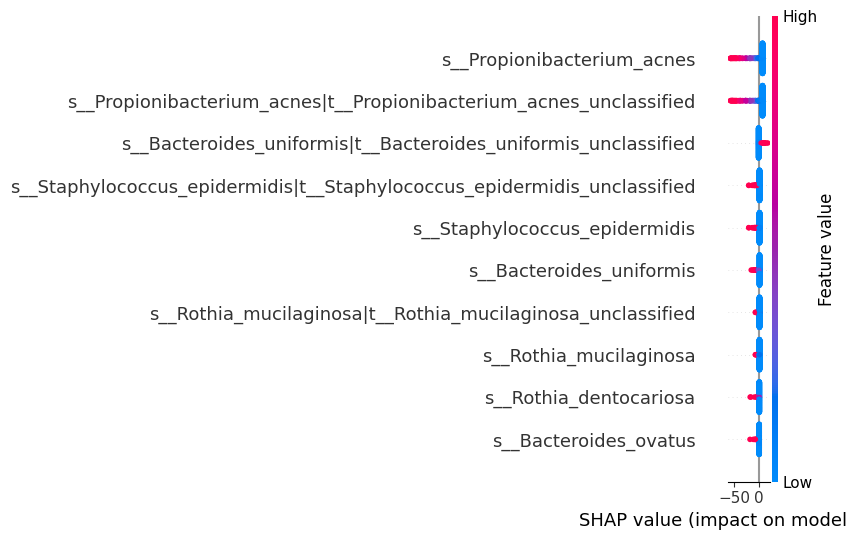

In [ ]:
#Global
explainer = shap.LinearExplainer(clf_log, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names=df_vi.columns[1:].tolist(), max_display=shap_values.shape[1])
shap.summary_plot(shap_values, X_test, feature_names=df_vi.columns[1:].tolist(), max_display=10)

In [ ]:
# LOCAL ANALYSIS MODEL LOGISTIC (đây là biểu diễn minh họa tại 1 người theo index [0])
import shap
shap.initjs()
model = clf_log
masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(clf_log.fit(X_train,y_train), masker=masker)

shap_values = explainer(X_train)
shap.plots.force(shap_values[0])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


**THẬT RA CHỈ LÀ CÁCH VẼ KHÁC CỦA SHAP**

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


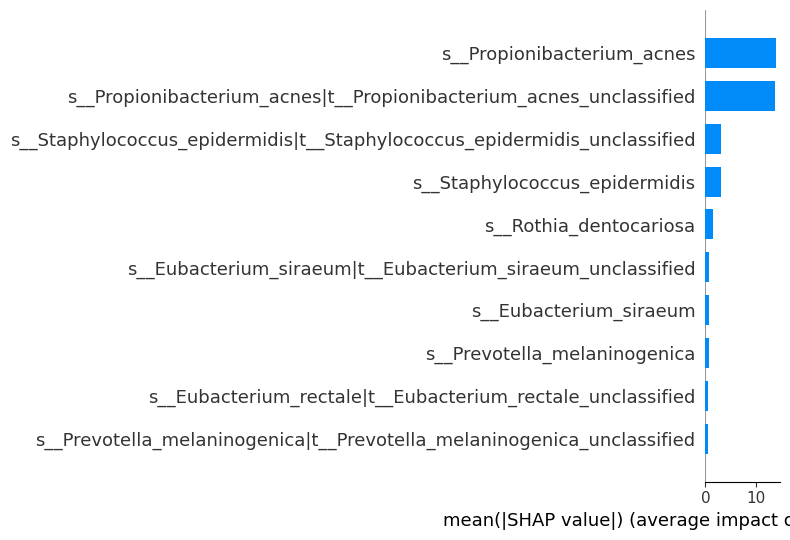

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=10)